In [32]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Model evaluation
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# XGBoost model
import xgboost as xgb

# Deep learning models with Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Pipeline for combining steps
from sklearn.pipeline import Pipeline

from keras.callbacks import EarlyStopping


In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\c22011387\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\c22011387\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv('netflix_reviews.csv')

In [4]:
# 检查缺失值
print(df.isnull().sum())

reviewId                    0
userName                    1
content                     2
score                       0
thumbsUpCount               0
reviewCreatedVersion    16239
at                          0
appVersion              16239
dtype: int64


In [5]:
# Data processing
# Remove rows with missing values for `userName` and `content`
df = df.dropna(subset=['userName', 'content'])

# Remove `reviewCreatedVersion` and `appVersion` columns
df = df.drop(columns=['reviewCreatedVersion', 'appVersion'])

# Text cleaning functions
def clean_text(text):
    text = re.sub(r'<.*?>', '', text) 
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

# Function to check whether it contains non-English characters
def is_english(text):
    return re.fullmatch(r'[a-zA-Z\s]*', text) is not None

# Functions for word segmentation and stop word removal
def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return filtered_tokens

df['cleaned_content'] = df['content'].apply(clean_text)
df = df[df['cleaned_content'].apply(is_english)]
df = df[df['cleaned_content'].str.strip() != '']
df['tokens'] = df['cleaned_content'].apply(tokenize_and_remove_stopwords)

# Select the required columns: 'cleaned_content' and 'thumbsUpCount'
df = df[['cleaned_content', 'thumbsUpCount']]

# Remove rows where the value in the 'thumbsUpCount' column is NaN
df = df.dropna(subset=['thumbsUpCount'])

# Since 'thumbsUpCount' is a numerical data, it needs to be converted into a classification problem
# If thumbsUpCount > 0, mark it as 1 (useful), otherwise it is 0 (useless)
df['thumbsUpCount'] = df['thumbsUpCount'].apply(lambda x: 1 if x > 0 else 0)

df.to_csv('Usefulness Score Model_TF-IDF.csv', index=False)

In [6]:
# Convert text data into numerical features
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_content'])

# Target variable
y = df['thumbsUpCount']

# Divide into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Overall Accuracy:  76.48%
Logistic Regression Model Report:
              precision    recall  f1-score   support

           0       0.78      0.92      0.84     15373
           1       0.70      0.43      0.54      7025

    accuracy                           0.76     22398
   macro avg       0.74      0.67      0.69     22398
weighted avg       0.76      0.76      0.75     22398



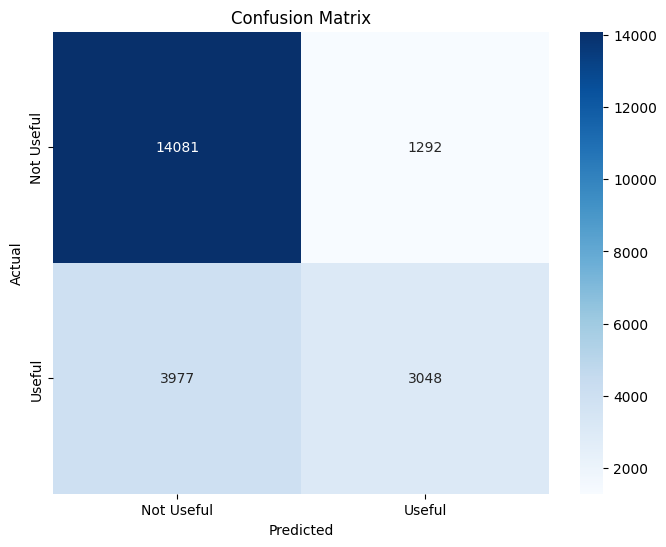

In [7]:
# 1. Logistic Regression Model
model = LogisticRegression()

# Training the model
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# Output overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred) * 100
print("Overall Accuracy:  {:.2f}%".format(overall_accuracy))

# Output classification report
print("Logistic Regression Model Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Useful', 'Useful'], yticklabels=['Not Useful', 'Useful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Generate usefulness score
df['usefulness_score'] = model.predict_proba(vectorizer.transform(df['cleaned_content']))[:, 1]

Overall Accuracy:  72.47%
Logistic Regression Model + Class Weight Report:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79     15373
           1       0.55      0.67      0.61      7025

    accuracy                           0.72     22398
   macro avg       0.69      0.71      0.70     22398
weighted avg       0.74      0.72      0.73     22398



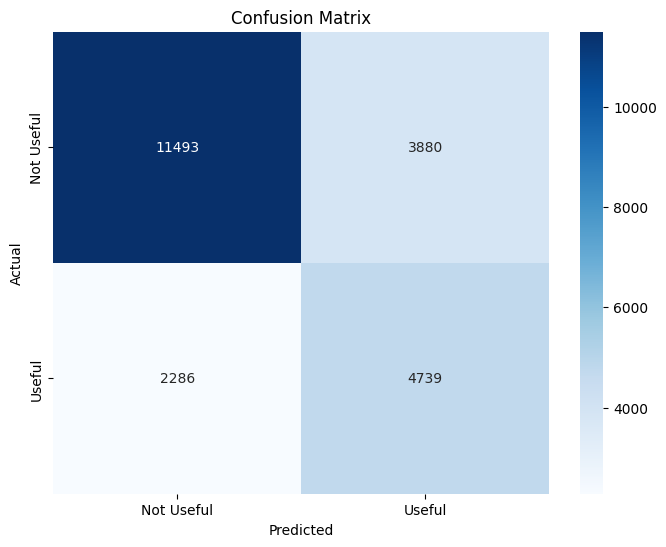

In [8]:
# 2.Logistic Regression Model + Class weight
# Use class_weight='balanced' to balance data in logistic regression
model = LogisticRegression(class_weight='balanced', random_state=42)


model.fit(X_train, y_train)

y_pred = model.predict(X_test)

overall_accuracy = accuracy_score(y_test, y_pred) * 100
print("Overall Accuracy:  {:.2f}%".format(overall_accuracy))

print("Logistic Regression Model + Class Weight Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Useful', 'Useful'], yticklabels=['Not Useful', 'Useful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

df['usefulness_score'] = model.predict_proba(vectorizer.transform(df['cleaned_content']))[:, 1]

Overall Accuracy:  68.64%
Logistic Regression Model + Increase Iterations Report:
              precision    recall  f1-score   support

           0       0.69      1.00      0.81     15373
           1       0.00      0.00      0.00      7025

    accuracy                           0.69     22398
   macro avg       0.34      0.50      0.41     22398
weighted avg       0.47      0.69      0.56     22398



C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

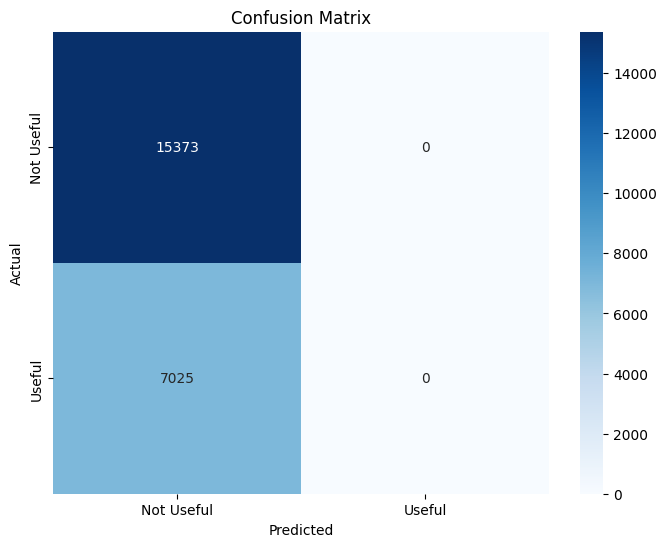

In [9]:
# 3.Logistic Regression Model + Increase Iterations
# Solve the convergence problem: increase the number of iterations, data scaling 解决收敛问题:增加迭代次数,数据缩放
# Standardize feature data   对特征数据进行标准化
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Using a logistic regression model with increased max_iter  使用增加 max_iter 的逻辑回归模型
model = LogisticRegression(class_weight='balanced', max_iter=200, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test)

overall_accuracy = accuracy_score(y_test, y_pred) * 100
print("Overall Accuracy:  {:.2f}%".format(overall_accuracy))
print("Logistic Regression Model + Increase Iterations Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Useful', 'Useful'], yticklabels=['Not Useful', 'Useful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

df['usefulness_score'] = model.predict_proba(vectorizer.transform(df['cleaned_content']))[:, 1]

In [ ]:
#  Logistic Regression code Summary
# 1. Logistic Regression Model
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 2.Logistic Regression Model + Class weight
# Use class_weight='balanced' to balance data in logistic regression
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


# 3.Logistic Regression Model + Increase Iterations
# Solve the convergence problem: increase the number of iterations, data scaling 解决收敛问题:增加迭代次数,数据缩放
# Standardize feature data   对特征数据进行标准化
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Using a logistic regression model with increased max_iter  使用增加 max_iter 的逻辑回归模型
model = LogisticRegression(class_weight='balanced', max_iter=200, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test)

overall_accuracy = accuracy_score(y_test, y_pred) * 100
print("Overall Accuracy:  {:.2f}%".format(overall_accuracy))
print("Logistic Regression Model + Increase Iterations Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Useful', 'Useful'], yticklabels=['Not Useful', 'Useful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

df['usefulness_score'] = model.predict_proba(vectorizer.transform(df['cleaned_content']))[:, 1]

Overall Accuracy:  75.21%
Random Forest Model Report:
              precision    recall  f1-score   support

           0       0.75      0.95      0.84     15373
           1       0.75      0.31      0.44      7025

    accuracy                           0.75     22398
   macro avg       0.75      0.63      0.64     22398
weighted avg       0.75      0.75      0.72     22398



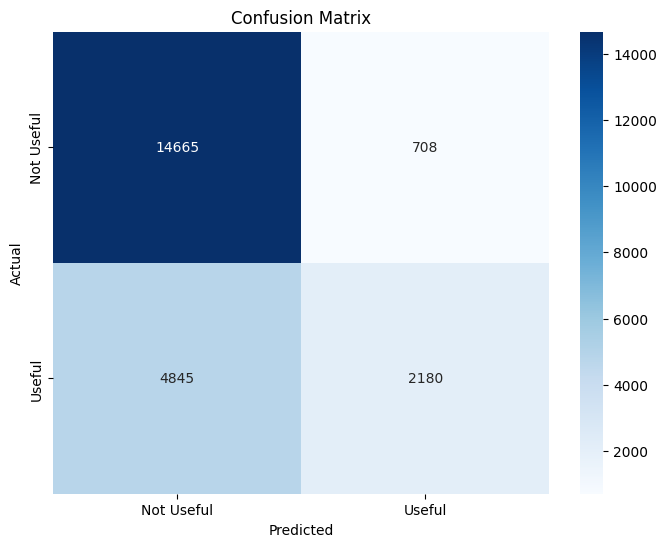

In [10]:
# 4.Random Forest Model
model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

overall_accuracy = accuracy_score(y_test, y_pred) * 100
print("Overall Accuracy:  {:.2f}%".format(overall_accuracy))

print("Random Forest Model Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Useful', 'Useful'], yticklabels=['Not Useful', 'Useful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

df['usefulness_score'] = model.predict_proba(vectorizer.transform(df['cleaned_content']))[:, 1]


Overall Accuracy:  75.39%
Random Forest Model + Class Weight Report:
              precision    recall  f1-score   support

           0       0.76      0.93      0.84     15373
           1       0.71      0.37      0.48      7025

    accuracy                           0.75     22398
   macro avg       0.74      0.65      0.66     22398
weighted avg       0.75      0.75      0.73     22398



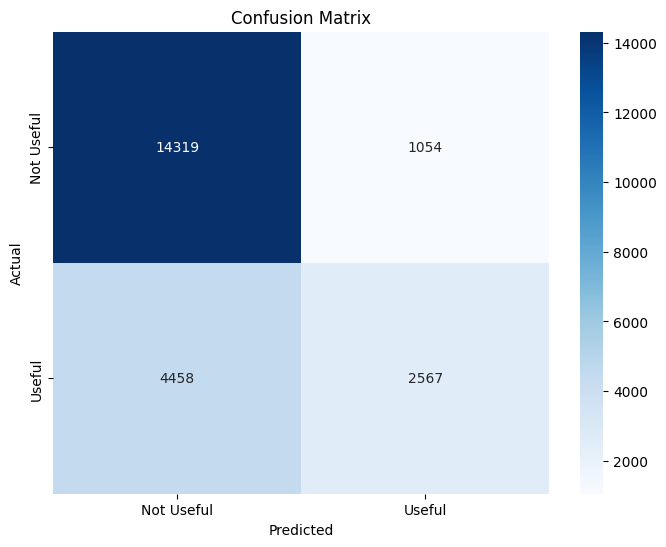

In [11]:
# 5.Random Forest Model + Class Weight

# Calculating Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}


model = RandomForestClassifier(class_weight=class_weights_dict, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

overall_accuracy = accuracy_score(y_test, y_pred) * 100
print("Overall Accuracy:  {:.2f}%".format(overall_accuracy))

print("Random Forest Model + Class Weight Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Useful', 'Useful'], yticklabels=['Not Useful', 'Useful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

df['usefulness_score'] = model.predict_proba(vectorizer.transform(df['cleaned_content']))[:, 1]


Best parameters (first stage): {'max_depth': 20, 'n_estimators': 100}
Best parameters (second stage): {'min_samples_split': 5}
Overall Accuracy:  73.69%
Random Forest Model + Hyperparameter Tuning with GridSearchCV Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81     15373
           1       0.58      0.58      0.58      7025

    accuracy                           0.74     22398
   macro avg       0.69      0.69      0.69     22398
weighted avg       0.74      0.74      0.74     22398



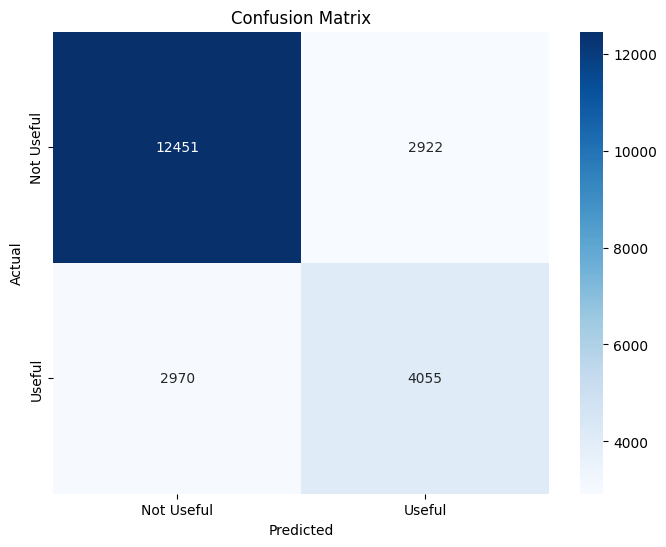

In [13]:
# 6.Random Forest Model + Hyperparameter Tuning with GridSearchCV
# Hyperparameter Tuning: Use GridSearchCV to tune the hyperparameters of random forests超参数调优：使用GridSearchCV来调优随机森林的超参数

# Initialize the RandomForestClassifier 实例化随机森林模型
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# First grid search 第一次网格搜索
param_grid_1 = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20]
}

grid_search_1 = GridSearchCV(estimator=rf, param_grid=param_grid_1, cv=5, scoring='f1', n_jobs=1)
grid_search_1.fit(X_train, y_train)
print(f"Best parameters (first stage): {grid_search_1.best_params_}")

# Further refine the search based on the results of the first stage 基于第一阶段的结果进一步细化搜索
best_params_stage_1 = grid_search_1.best_params_
param_grid_2 = {
    'min_samples_split': [2, 5, 10]
}

# Use the best parameters from the first stage 使用从第一阶段得到的最佳参数
rf = RandomForestClassifier(
    n_estimators=best_params_stage_1['n_estimators'],
    max_depth=best_params_stage_1['max_depth'],
    class_weight='balanced',
    random_state=42
)

grid_search_2 = GridSearchCV(estimator=rf, param_grid=param_grid_2, cv=5, scoring='f1', n_jobs=1)
grid_search_2.fit(X_train, y_train)

# Output the best parameters 输出最佳参数
print(f"Best parameters (second stage): {grid_search_2.best_params_}")


# Model trained with optimal parameters 使用最佳参数训练的模型
best_rf = grid_search_2.best_estimator_


y_pred = best_rf.predict(X_test)

overall_accuracy = accuracy_score(y_test, y_pred) * 100
print("Overall Accuracy:  {:.2f}%".format(overall_accuracy))

print("Random Forest Model + Hyperparameter Tuning with GridSearchCV Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Useful', 'Useful'], yticklabels=['Not Useful', 'Useful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

df['usefulness_score'] = model.predict_proba(vectorizer.transform(df['cleaned_content']))[:, 1]



In [ ]:
# Random Forest code Summary
# 4.Random Forest Model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 5.Random Forest Model + Class Weight
# Calculating Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
model = RandomForestClassifier(class_weight=class_weights_dict, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 6.Random Forest Model + Hyperparameter Tuning with GridSearchCV
# Hyperparameter Tuning: Use GridSearchCV to tune the hyperparameters of random forests超参数调优：使用GridSearchCV来调优随机森林的超参数
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# First grid search 第一次网格搜索
param_grid_1 = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20]
}
grid_search_1 = GridSearchCV(estimator=rf, param_grid=param_grid_1, cv=5, scoring='f1', n_jobs=1)
grid_search_1.fit(X_train, y_train)
print(f"Best parameters (first stage): {grid_search_1.best_params_}")

# Further refine the search based on the results of the first stage 基于第一阶段的结果进一步细化搜索
best_params_stage_1 = grid_search_1.best_params_
param_grid_2 = {
    'min_samples_split': [2, 5, 10]
}

# Use the best parameters from the first stage 使用从第一阶段得到的最佳参数
rf = RandomForestClassifier(
    n_estimators=best_params_stage_1['n_estimators'],
    max_depth=best_params_stage_1['max_depth'],
    class_weight='balanced',
    random_state=42
)

grid_search_2 = GridSearchCV(estimator=rf, param_grid=param_grid_2, cv=5, scoring='f1', n_jobs=1)
grid_search_2.fit(X_train, y_train)

# Output the best parameters 输出最佳参数
print(f"Best parameters (second stage): {grid_search_2.best_params_}")


# Model trained with optimal parameters 使用最佳参数训练的模型
best_rf = grid_search_2.best_estimator_


y_pred = best_rf.predict(X_test)

overall_accuracy = accuracy_score(y_test, y_pred) * 100
print("Overall Accuracy:  {:.2f}%".format(overall_accuracy))

print("Random Forest Model + Hyperparameter Tuning with GridSearchCV Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Useful', 'Useful'], yticklabels=['Not Useful', 'Useful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

df['usefulness_score'] = model.predict_proba(vectorizer.transform(df['cleaned_content']))[:, 1]



Overall Accuracy:  75.39%
XGBoost Model Report:
              precision    recall  f1-score   support

           0       0.76      0.93      0.84     15373
           1       0.71      0.37      0.48      7025

    accuracy                           0.75     22398
   macro avg       0.74      0.65      0.66     22398
weighted avg       0.75      0.75      0.73     22398



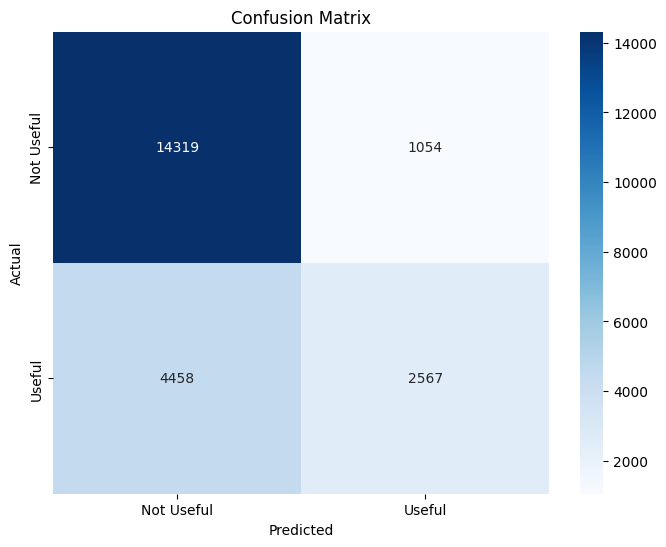

In [14]:
# 7.Use ensemble learning model, XGBoost

# Divide the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBClassifier(scale_pos_weight=class_weights_dict[1]/class_weights_dict[0], random_state=42)

xgb_model.fit(X_train, y_train)

y_pred = model.predict(X_test)

overall_accuracy = accuracy_score(y_test, y_pred) * 100
print("Overall Accuracy:  {:.2f}%".format(overall_accuracy))
print("XGBoost Model Report:")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Useful', 'Useful'], yticklabels=['Not Useful', 'Useful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

df['usefulness_score'] = model.predict_proba(vectorizer.transform(df['cleaned_content']))[:, 1]


Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'scale_pos_weight': 2.198046663049376}
Overall Accuracy:  73.69%
XGBoost Model + Tuning with GridSearchCV Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80     15373
           1       0.57      0.63      0.60      7025

    accuracy                           0.74     22398
   macro avg       0.70      0.71      0.70     22398
weighted avg       0.74      0.74      0.74     22398



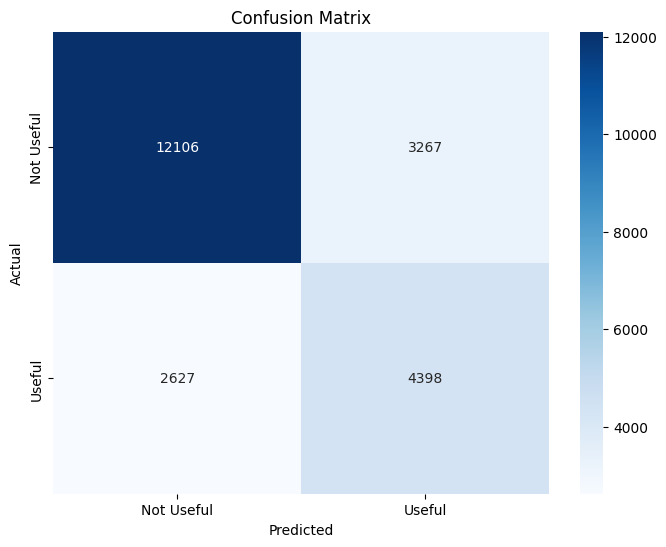

In [15]:
# 8.XGBoost Model + Tuning with GridSearchCV

# Calculating Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Defining the parameter grid
param_grid = {
    'max_depth': [7],
    'learning_rate': [0.1],
    'n_estimators': [50],
    'scale_pos_weight': [1, class_weights_dict[1] / class_weights_dict[0]]
}

xgb_model = xgb.XGBClassifier(random_state=42)

# Hyperparameter optimization using GridSearchCV
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Output the best parameters
print("Best Parameters:", grid_search.best_params_)

# Make predictions using the best parameters
best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

overall_accuracy = accuracy_score(y_test, y_pred) * 100
print("Overall Accuracy:  {:.2f}%".format(overall_accuracy))
print("XGBoost Model + Tuning with GridSearchCV Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Useful', 'Useful'], yticklabels=['Not Useful', 'Useful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

df['usefulness_score'] = model.predict_proba(vectorizer.transform(df['cleaned_content']))[:, 1]

In [ ]:
# XGBoost code Summmary
# 7.Use ensemble learning model, XGBoost

# Divide the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_model = xgb.XGBClassifier(scale_pos_weight=class_weights_dict[1]/class_weights_dict[0], random_state=42)
xgb_model.fit(X_train, y_train)


# 8.XGBoost Model + Tuning with GridSearchCV

# Calculating Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Defining the parameter grid
param_grid = {
    'max_depth': [7],
    'learning_rate': [0.1],
    'n_estimators': [50],
    'scale_pos_weight': [1, class_weights_dict[1] / class_weights_dict[0]]
}

xgb_model = xgb.XGBClassifier(random_state=42)

# Hyperparameter optimization using GridSearchCV
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Output the best parameters
print("Best Parameters:", grid_search.best_params_)
# Make predictions using the best parameters
best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

overall_accuracy = accuracy_score(y_test, y_pred) * 100
print("Overall Accuracy:  {:.2f}%".format(overall_accuracy))
print("XGBoost Model + Tuning with GridSearchCV Report:")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Useful', 'Useful'], yticklabels=['Not Useful', 'Useful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
df['usefulness_score'] = model.predict_proba(vectorizer.transform(df['cleaned_content']))[:, 1]

In [25]:
# Prepare data for LSTM model
# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)  
tokenizer.fit_on_texts(df['cleaned_content'])
X = tokenizer.texts_to_sequences(df['cleaned_content'])

# Padding sequences to ensure uniform input length
maxlen = 100  
X = pad_sequences(X, padding='post', maxlen=maxlen)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['thumbsUpCount'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to categorical format
num_classes = len(np.unique(y))  # Number of unique classes
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 100, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_12 (Bidirectional)     │ (None, 100, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_13 (Bidirectional)     │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 837,890 (3.20 MB)

 Trainable params: 837,890 (3.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 193s 133ms/step - accuracy: 0.5270 - loss: 1.1839 - val_accuracy: 0.5516 - val_loss: 0.7562
Epoch 2/5
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 219s 156ms/step - accuracy: 0.5939 - loss: 1.1035 - val_accuracy: 0.5555 - val_loss: 0.7987
Epoch 3/5
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 221s 158ms/step - accuracy: 0.6217 - loss: 1.0554 - val_accuracy: 0.6190 - val_loss: 0.7107
Epoch 4/5
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 221s 158ms/step - accuracy: 0.6519 - loss: 1.0050 - val_accuracy: 0.6012 - val_loss: 0.7211
Epoch 5/5
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 221s 158ms/step - accuracy: 0.6722 - loss: 0.9582 - val_accuracy: 0.6415 - val_loss: 0.6984
700/700 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step
Overall Accuracy:  64.15%
LSTM model Report:
              precision    recall  f1-score   support

           0       0.84      0.58      0.69     15373
           1       0.46      0.77      0.57      7025

    accuracy                           0.64     22398
   macro avg       0.65      

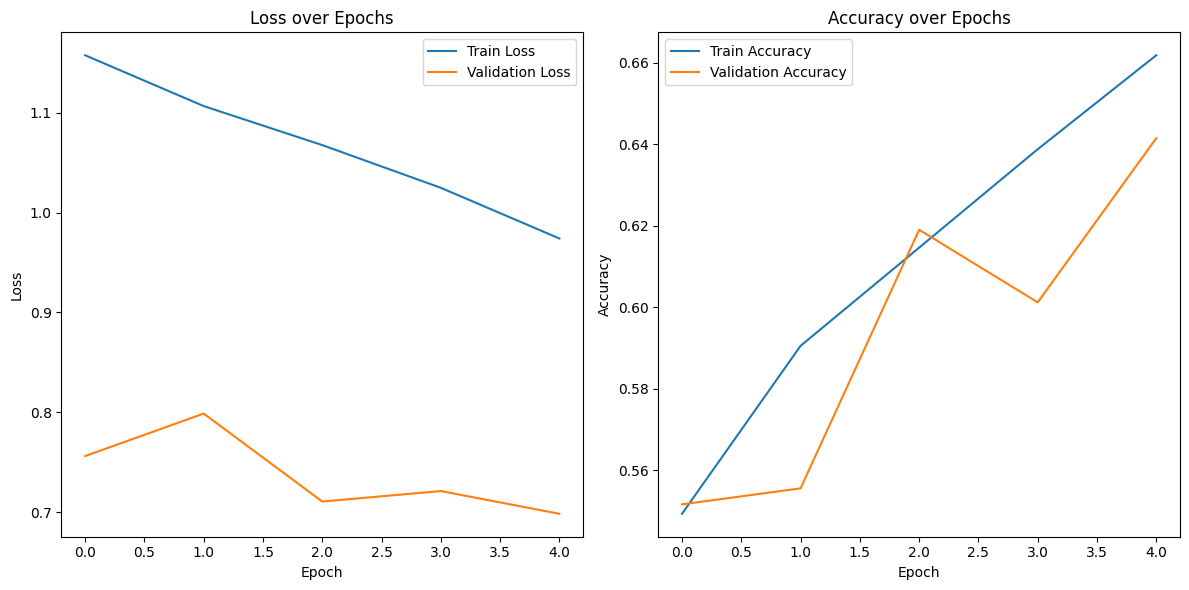

3500/3500 ━━━━━━━━━━━━━━━━━━━━ 116s 33ms/step


In [28]:
# 1.LSTM model
# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_shape=(100,))) 
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=64)))
model.add(Dropout(0.5))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), class_weight={0: 1, 1: 5})

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

target_names = [str(label) for label in label_encoder.classes_]

# Print model evaluation report
print("Overall Accuracy:  {:.2f}%".format(accuracy_score(y_test_classes, y_pred_classes) * 100))
print("LSTM model Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=target_names))

# Plot training accuracy and loss
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

df['usefulness_score'] = model.predict(X)[:, 1]

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (None, 100, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_18 (Bidirectional)     │ (None, 100, 256)            │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_19 (Bidirectional)     │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,297,922 (4.95 MB)

 Trainable params: 1,297,922 (4.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 742s 526ms/step - accuracy: 0.5036 - loss: 2.1866 - val_accuracy: 0.6065 - val_loss: 0.7504
Epoch 2/10
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 810s 579ms/step - accuracy: 0.5855 - loss: 1.1359 - val_accuracy: 0.6602 - val_loss: 0.7251
Epoch 3/10
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 838s 599ms/step - accuracy: 0.5963 - loss: 1.1265 - val_accuracy: 0.5856 - val_loss: 0.7527
Epoch 4/10
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 830s 593ms/step - accuracy: 0.6103 - loss: 1.1109 - val_accuracy: 0.6068 - val_loss: 0.7987
Epoch 5/10
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 825s 590ms/step - accuracy: 0.6232 - loss: 1.1108 - val_accuracy: 0.5271 - val_loss: 0.8671
700/700 ━━━━━━━━━━━━━━━━━━━━ 52s 74ms/step
Overall Accuracy:  66.02%
LSTM model Report:
              precision    recall  f1-score   support

           0       0.86      0.60      0.71     15373
           1       0.48      0.79      0.59      7025

    accuracy                           0.66     22398
   macro avg       0.67 

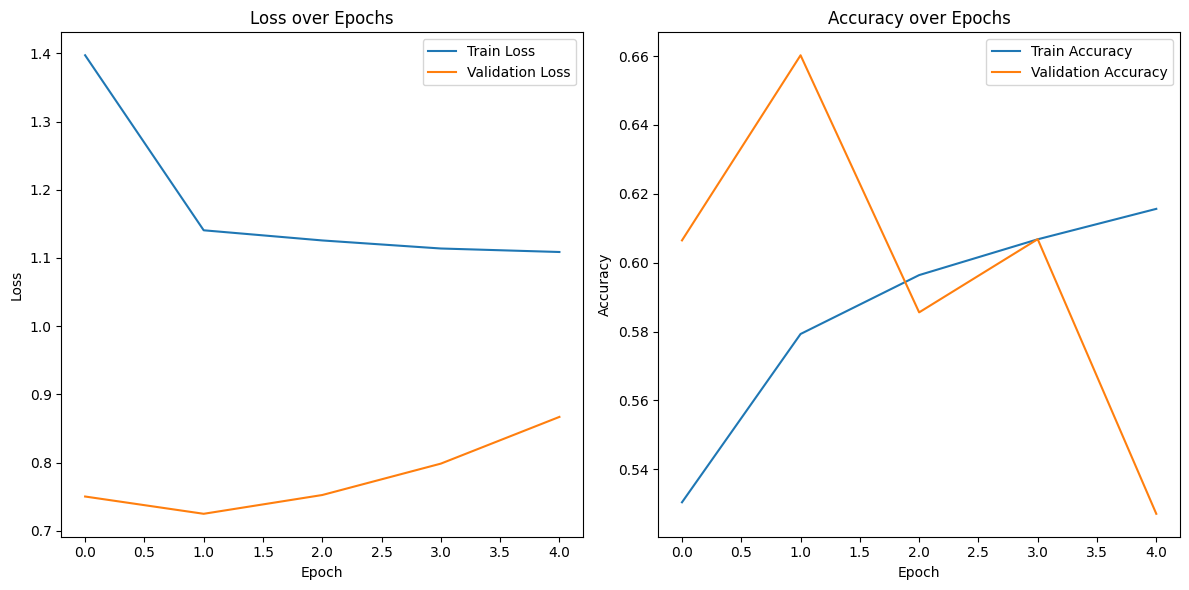

3500/3500 ━━━━━━━━━━━━━━━━━━━━ 247s 71ms/step


In [33]:
# 2.LSTM Model,Increased units and L2 regularization
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_shape=(100,))) 
model.add(Bidirectional(LSTM(units=128, return_sequences=True, kernel_regularizer='l2')))  # Increased units and L2 regularization
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=128, kernel_regularizer='l2')))  # Increased units and L2 regularization
model.add(Dropout(0.5))
model.add(Dense(units=num_classes, activation='softmax'))

# 2. Compile the Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# 3. Set Up Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 4. Train the Model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), 
                    class_weight={0: 1, 1: 5}, callbacks=[early_stopping])

# 5. Make Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Define target names for classification report
target_names = [str(label) for label in label_encoder.classes_]

# 6. Print Model Evaluation Report
print("Overall Accuracy:  {:.2f}%".format(accuracy_score(y_test_classes, y_pred_classes) * 100))
print("LSTM model Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=target_names))

# 7. Plot Training Accuracy and Loss
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# 8. Predict Usefulness Scores
df['usefulness_score'] = model.predict(X)[:, 1]

In [ ]:
#  LSTM code Summary
# 1.LSTM model
# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_shape=(100,))) 
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=64)))
model.add(Dropout(0.5))
model.add(Dense(units=num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), class_weight={0: 1, 1: 5})


# 2.LSTM Model,Increased units and L2 regularization
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_shape=(100,))) 
model.add(Bidirectional(LSTM(units=128, return_sequences=True, kernel_regularizer='l2')))  # Increased units and L2 regularization
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=128, kernel_regularizer='l2')))  # Increased units and L2 regularization
model.add(Dropout(0.5))
model.add(Dense(units=num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 3. Set Up Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), 
                    class_weight={0: 1, 1: 5}, callbacks=[early_stopping])

# 5. Make Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Define target names for classification report
target_names = [str(label) for label in label_encoder.classes_]

# 6. Print Model Evaluation Report
print("Overall Accuracy:  {:.2f}%".format(accuracy_score(y_test_classes, y_pred_classes) * 100))
print("LSTM model Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=target_names))

# 7. Plot Training Accuracy and Loss
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# 8. Predict Usefulness Scores
df['usefulness_score'] = model.predict(X)[:, 1]